## Bateman Equations for Multiple Decay - B&W version of Fig 7a,b

The calculations in this Python Jupyter notebook investigate solutions to a multi-step reaction model describing the successive dechlorination of DDE to DDMU and finally DDNU, as discussed in Eganhouse and Pontolillo (2008) and Eganhouse et al. (in review). The calculations produce Figure 7 in the draft manuscript.

R.P. Eganhouse, J. Pontolillo, Assessment of 1-chloro-4-[2,2-dichloro-1-(4-chlorophenyl)ethenyl]benzene (DDE) transformation rates on the Palos Verdes Shelf, CA,  U.S.G.S. Open-File Report 2007-1362, U.S. Geological Survey, Reston, VA, 2008, pp. 124.

R. P. Eganhouse, C. R. Sherwood, J. Pontolillo, B. D. Edwards, and P. J. Dickhudt, Reductive dechlorination rates of 4,4’-DDE (1-chloro-4-[2,2-dichloro-1-(4-chlorophenyl)ethenyl]benzene) in sediments of the Palos Verdes Shelf, CA. Manuscript in review for submission to Marine Chemistry.

The data associated with these calculations is included.

A second notebook `Bateman_May_calcs_forecast` is used to produce forecasts through 2100 and used to generate Figure S-9 in the Supplementary Data.

This is a version of `Bateman_May_calcs` that produces a gray-scale version of the figures.

#### Dependencies

scipy, matplotlib, and numpy are fairly standard in most Python distributions.
lmfit (https://lmfit.github.io/lmfit-py/) "provides a high-level interface to non-linear optimization and curve fitting problems".

Written in Python 3.6 in a Jupyter notebook. The `README.md` file in this repository describes how to create a conda environment that fulfills these dependencies.

Christopher R. Sherwood, USGS. *See disclaimer and license in this repository.*

##### Import dependencies
LmFit (https://lmfit.github.io/lmfit-py/) "provides a high-level interface to non-linear optimization and curve fitting problems".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import lmfit as lm

%matplotlib inline

# The next line controls whether bare variable names print in the output box
# As suggested in https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

#### The next cell contains key switches
Identify which site to process. Results from both sites are included in Figure 7.

Choose whether to adjust the inventories according to PCB anomolies. If selected adjust_inventories is True then computations are performed using adjusted inventories, as presented in Figure 7 and discussed in the Supplementary Data.

Choose whether to include estimates of the standard deviations of inventories in the objective function. If use_eps it True, the values in the objective function are normalized by the standard deviation of the observations, as in Figure 7. If not, the denominator is set to one.

In [2]:
# Pick one of the two sites
#site = 'Site 3C' # creates part a of figure
site = 'Site 6C'  # creates part b of figure

# Adjust using PCBs?
adjust_inventories=True # True reproduces results presented / discussed in paper

# Use std. deviations in chi-square calculation?
use_eps=True # True reproduces results presented / discussed in paper

In [3]:
# These strings are used to build filenames for the output figures and set y-axis limits
itext = '_'
if adjust_inventories:
    itext = "_adj_"
etext = '_'
if use_eps:
    etext = "_eps_"
yl = [0., 1.5]
if site=='Site 6C':
    yl = [0., 3.5]

##### These data are from spreadsheet e-mailed to CRS from Bob Eganhouse 16-Dec-2016 'Inventories for C.Sherwood 12-16-2016.xlsx'
Columns represent: time (decimal years), p,p'-DDE, p,p'-DDMU, p,p'-DDNU, PCB 118, PCB 153, PBC 138, PCB28, and PCB70 ($\mu mol \: cm^{-2}$)

In [4]:
# Load data from the selected site.
# This data comes from the spreadsheet "Inventories for C. Sherwood 12-16-2016.xlsx" which was modified
# and resent to CRS on 4/7/2016. The modifications added inventories of the congeners PCB28 and PBC70.
cols=["Year","DDE","DDMU","DDNU","PCB118","PCB153","PCB138","PCB28","PCB70"]
A=np.array([\
    [1981.27,1.34,0.07,0.004,0.0081,0.0062,0.0076,0.0025,0.0077],\
    [1992.51,0.71,0.25,0.012,0.0066,0.0049,0.0064,0.0017,0.0057],\
    [2003.58,0.39,0.32,0.036,0.0050,0.0037,0.0050,0.0012,0.0038],\
    [2009.23,0.38,0.52,0.069,0.0076,0.0076,0.0085,0.0030,0.0057],\
    [2010.31,0.41,0.52,0.085,0.0075,0.0072,0.0079,0.0033,0.0061]])

B=np.array([\
    [1992.52,3.07,0.67,0.026,0.0182,0.0119,0.0152,0.0084,0.0216],\
    [2003.58,2.75,0.87,0.072,0.0177,0.0122,0.0158,0.0106,0.0230],\
    [2009.23,2.37,0.75,0.095,0.0172,0.0095,0.0134,0.0112,0.0271],\
    [2010.31,1.16,0.43,0.046,0.0079,0.0054,0.0065,0.0032,0.0104]])

# Load data for the selected site
if site == 'Site 3C':  
    t = A[:,0]
    DDE=A[:,1]
    DDMU=A[:,2]
    DDNU=A[:,3]
    PCB118=A[:,4]
    PCB153=A[:,5]
    PCB138=A[:,6]
    PCB28=A[:,7]
    PCB70=A[:,8]
    print("Data from {0} with shape {1}".format(site,A.shape))
    print('\n'.join([''.join(['{:5.4f}  '.format(item) for item in row]) 
      for row in A]))

if site == 'Site 6C':  
    t = B[:,0]
    DDE=B[:,1]
    DDMU=B[:,2]
    DDNU=B[:,3]
    PCB118=B[:,4]
    PCB153=B[:,5]
    PCB138=B[:,6]
    PCB28=B[:,7]
    PCB70=B[:,8]
    print("Data from {0} with shape {1}".format(site,B.shape))
    print('\n'.join([''.join(['{:5.4f}  '.format(item) for item in row]) 
      for row in B]))

Data from Site 6C with shape (4, 9)
1992.5200  3.0700  0.6700  0.0260  0.0182  0.0119  0.0152  0.0084  0.0216  
2003.5800  2.7500  0.8700  0.0720  0.0177  0.0122  0.0158  0.0106  0.0230  
2009.2300  2.3700  0.7500  0.0950  0.0172  0.0095  0.0134  0.0112  0.0271  
2010.3100  1.1600  0.4300  0.0460  0.0079  0.0054  0.0065  0.0032  0.0104  


##### Make some plots of inventory over time

In [5]:
# calculate adjustment according to mean of all PCBs inventory
adj_PCB118 = np.mean(PCB118)/PCB118
adj_PCB153 = np.mean(PCB153)/PCB153
adj_PCB138 = np.mean(PCB138)/PCB138
adj_PCB28  =  np.mean(PCB28)/PCB28
adj_PCB70  = np.mean(PCB70)/PCB70

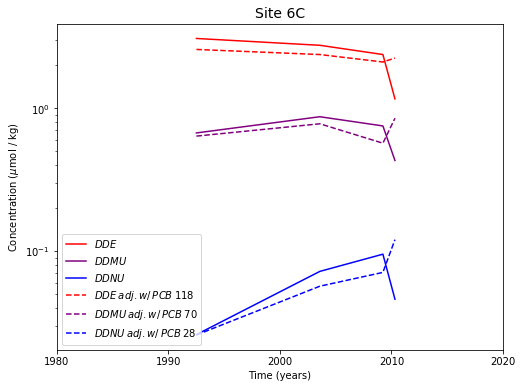

In [6]:
InteractiveShell.ast_node_interactivity = "none"
# calculate first-order RDC for 
fig = plt.figure(figsize=(8,6))
plt.semilogy(t,DDE,label='$DDE$',color='red')
plt.semilogy(t,DDMU,label='$DDMU$',color='purple')
plt.semilogy(t,DDNU,label='$DDNU$',color='blue')

plt.semilogy(t,DDE*adj_PCB118,label='$DDE \:adj. w/ \:PCB \: 118$',color='red',linestyle='dashed')
plt.semilogy(t,DDMU*adj_PCB70,label='$DDMU \:adj. w/  \: PCB \: 70$',color='purple',linestyle='dashed')
plt.semilogy(t,DDNU*adj_PCB28,label='$DDNU \:adj. w/  \: PCB \: 28$',color='blue',linestyle='dashed')

plt.xlabel('Time (years)')
plt.ylabel('Concentration ($\mu$mol / kg)')
if site=='Site 3C':
    plt.legend(loc='lower right')
if site=='Site 6C':
    plt.legend(loc='lower left')
plt.xticks(np.arange(1980,2020+1,10))
ttle = site
plt.title(ttle,fontsize=14)
figname = site+"inventory_time_series_rev.png"
plt.savefig(figname,bbox_inches='tight')

##### Define the model
This defines a three-component model with no global decay rate, and no fourth-generation product. It is a coupled set of ordinary differential equations that, in the model, are integrated with the `scipy.integrate.odeint` function.

In [7]:
# Version of ODE with three-generation transformation and only three transfer terms
def dcdt3(c, t, k):
    dfdt = np.zeros(3)
    dfdt[0] = c[0]* -k[0]
    dfdt[1] = c[1]* -k[1] + c[0]*k[0]
    dfdt[2] = c[2]* -k[2] + c[1]*k[1]
    return dfdt

##### Define the objective function to minimize
This function returns the quantity that lmfit will try to minimize. It returns vectors of length `nt`, the number of data points (and corresponding model estimates). The RMS of these vectors (concatenated) is the chi-square goodness of fit.

In [8]:
# Objective function using ODE for three-generation transformation 
def residual3(params, t, data, eps_data):
    # Data is passed as a vector
    # Index on length of time array to find intitial concentrations
    nt = t.size
    k = np.array((params['k1'],params['k2'],params['k3']))
    C0 = np.array((data[0],data[nt],data[2*nt]))
    C = integrate.odeint(dcdt3,C0,t, args = (k,))
    model = np.concatenate((C[:,0],C[:,1],C[:,2]))
    return (data-model)**2/eps_data**2
    

In [9]:
# guess at std. error in measurements per conv. with R.Eganhouse
stde_DDE  = 0.05          #RE suggests 0.05
stde_DDMU = 0.1          #RE suggested 0.1
stde_DDNU = 0.1          #RE suggested 0.1
stde_PCB  = 0.2          # std. error of measurements is around 0.2
eps_DDE  = stde_DDE*DDE  
eps_DDMU = stde_DDMU*DDMU
eps_DDNU = stde_DDNU*DDNU
eps_PCB118 = stde_PCB*PCB118
eps_PCB28 = stde_PCB*PCB28
eps_PCB70 = stde_PCB*PCB70
# Note: we just use the std. error, because the PCB adjustments are normalized.

#### Fit the multi-step decay model, with or without PCB adjustment

In [10]:
# Put data for all compounds in a single vector
nt = t.size
data = np.concatenate((DDE,DDMU,DDNU))
if(adjust_inventories):
    data = np.concatenate((DDE*adj_PCB118,DDMU*adj_PCB70,DDNU*adj_PCB28))

eps_data = np.ones_like(data)
data_ebar = np.concatenate((eps_DDE,eps_DDMU,eps_DDNU))
if(use_eps):
    eps_data = np.concatenate((eps_DDE,eps_DDMU,eps_DDNU))
    if(adjust_inventories):
        eps_data = np.concatenate((np.sqrt(eps_DDE**2+stde_PCB**2),\
                                   np.sqrt(eps_DDMU**2+stde_PCB**2),\
                                   np.sqrt(eps_DDNU**2+stde_PCB**2)))
        data_ebar = np.concatenate((np.sqrt(eps_DDE**2+stde_PCB**2),\
                                   np.sqrt(eps_DDMU**2+stde_PCB**2),\
                                   np.sqrt(eps_DDNU**2+stde_PCB**2)))

print('data')
print(data)
print('eps_data')
print(eps_data)

data
[ 2.57239011  2.36935028  2.10130814  2.23924051  0.63665509  0.77638043
  0.56803506  0.84862981  0.02584524  0.05671698  0.07082589  0.12003125]
eps_data
[ 0.25211555  0.2427061   0.23246989  0.20824025  0.21092416  0.21810319
  0.21360009  0.20457028  0.2000169   0.20012956  0.2002255   0.20005289]


residual3 shape: (12,)
RMS residuals: 2.5011491185429393

Fit to DDE, DDMU, and DDNU
 Site 6C
  Inventories adjusted by selected PCB inventories
  Using estimates of std. errors
[[Fit Statistics]]
    # function evals   = 63
    # data points      = 12
    # variables        = 3
    chi-square         = 0.450
    reduced chi-square = 0.050
    Akaike info crit   = -33.395
    Bayesian info crit = -31.941
[[Variables]]
    k1:   0.00961086 +/- 0.001229 (12.79%) (init= 0.4)
    k2:   0.02656324 +/- 0.004621 (17.40%) (init= 0.4)
    k3:   0.19968438 +/- 0.272057 (136.24%) (init= 0.4)
[[Correlations]] (unreported correlations are <  0.100)
    C(k1, k2)                    =  0.836 
    C(k2, k3)                    =  0.137 
    C(k1, k3)                    =  0.124 
4
(4,)
(4,)
(12,)


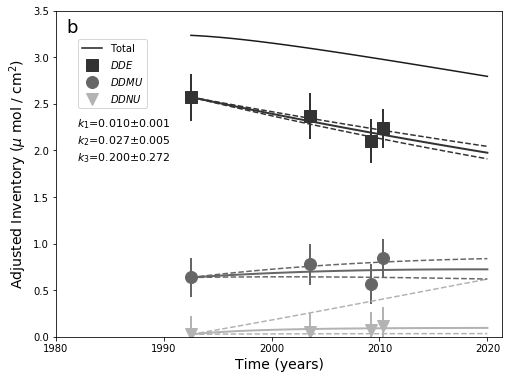

In [11]:
# Fit the multistep model                                 
# Make an instance of the lmfit.Parameters class
params = lm.Parameters()
# Initialize parameters with rough guess based on prior experimentation
params.add('k1',value = 0.4, min =0., max = 0.6)
params.add('k2',value = 0.4, min =0., max = 0.6)
params.add('k3',value = 0.4, min =0., max = 2.0)

# Test the ODE solver
k = np.array((params['k1'],params['k2'],params['k3']))
C0 = np.array((data[0],data[nt],data[2*nt]))
C = integrate.odeint(dcdt3,C0,t, args = (k,))
model = np.concatenate((C[:,0],C[:,1],C[:,2]))

# Test the objective function outside
res = residual3(params, t, data, np.ones_like(data))
print("residual3 shape:",np.shape(res))
print("RMS residuals: {:}".format( np.sqrt(np.mean(res**2))))

# Optimize the parameters using least-squares fit
out = lm.minimize(residual3, params, method='leastsq', args=(t,data,eps_data))

# Get the fitted rates
kf = np.zeros((3,))
kf[0]=out.params['k1'].value
kf[1]=out.params['k2'].value
kf[2]=out.params['k3'].value
ke = np.zeros((3,))
ke[0] = out.params['k1'].stderr
ke[1] = out.params['k2'].stderr
ke[2] = out.params['k3'].stderr

# Get fit metrics
chis = out.chisqr
chir = out.redchi

# Run the ODE solver with best-fit results
tm = np.linspace(t[0],2020.,50)
C0 = np.array((data[0],data[nt],data[2*nt]))
Cm = integrate.odeint(dcdt3,C0,tm, args = (kf,))

# now run it for all of the cases with +/- uncertainty
kmult = np.array((0.,1.,-1.))
kep = np.zeros((27,3))
Cc = np.zeros_like(Cm)
Cmax = np.zeros_like(Cm)
Cmin = np.zeros_like(Cm)
C1 = np.zeros((27,50))
C2 = np.zeros((27,50))
C3 = np.zeros((27,50))
n =0
for k in np.arange(3):
    for j in np.arange(3):
        for i in np.arange(3):
            kep[n][0]=max(0.,kf[0]+ke[0]*kmult[k])
            kep[n][1]=max(0.,kf[1]+ke[1]*kmult[i])
            kep[n][2]=max(0.,kf[2]+ke[2]*kmult[j])
            C0 = np.array((data[0],data[nt],data[2*nt]))
            Cc = integrate.odeint(dcdt3,C0,tm, args = (kep[n,:],))
            C1[n,:] = Cc[:,0]
            C2[n,:] = Cc[:,1]
            C3[n,:] = Cc[:,2]
            n=n+1

Cmax[:,0] = np.amax(C1,axis=0)
Cmin[:,0] = np.amin(C1,axis=0)
Cmax[:,1] = np.amax(C2,axis=0)
Cmin[:,1] = np.amin(C2,axis=0)
Cmax[:,2] = np.amax(C3,axis=0)
Cmin[:,2] = np.amin(C3,axis=0)

print('\nFit to DDE, DDMU, and DDNU')
print(" {}".format(site))
if(adjust_inventories):
    print("  Inventories adjusted by selected PCB inventories")
if(use_eps):
    print("  Using estimates of std. errors")
lm.report_fit(out)

print(nt)
print(np.shape(t))
print(np.shape(data[0:nt]))
print(np.shape(eps_data))


cDDE = (.2,.2,.2)
cDDMU = (.4,.4,.4)
cDDNU = (.7,.7,.7)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.plot(tm,Cm[:,0]+Cm[:,1]+Cm[:,2],'-',color=(.1,.1,.1),label="Total")
plt.plot(tm,Cmax[:,2],'--',color=cDDNU)
plt.plot(tm,Cmin[:,2],'--',color=cDDNU)
plt.plot(tm,Cmax[:,1],'--',color=cDDMU)
plt.plot(tm,Cmin[:,1],'--',color=cDDMU)
plt.plot(tm,Cmax[:,0],'--',color=cDDE)
plt.plot(tm,Cmin[:,0],'--',color=cDDE)
plt.plot(tm,Cm[:,2],'-', color=cDDNU,linewidth=2)
plt.plot(tm,Cm[:,1],'-', color=cDDMU,linewidth=2)
plt.plot(tm,Cm[:,0],'-', color=cDDE,linewidth=2)
plt.plot(t,data[0:nt],'s',color=cDDE,markersize=12,linestyle='None',label='$DDE$')
plt.plot(t,data[nt:2*nt],'o',color=cDDMU,markersize=12,linestyle='None',label='$DDMU$')
plt.plot(t,data[2*nt:3*nt],'v',color=cDDNU,markersize=12,linestyle='None',label='$DDNU$')
plt.errorbar(t,data[0:nt], yerr=data_ebar[0:nt],color=cDDE,elinewidth=2,linestyle='None')
plt.errorbar(t,data[nt:2*nt], yerr=data_ebar[nt:2*nt],color=cDDMU,elinewidth=2,linestyle='None')
plt.errorbar(t,data[2*nt:3*nt], yerr=data_ebar[2*nt:3*nt],color=cDDNU,elinewidth=2,linestyle='None')
plt.xticks(np.arange(1980,2020+1,10))
plt.xlabel(r'Time (years)', fontsize=14)

ax.set_ylim(yl)
plt.ylabel(r'Adjusted Inventory ($\mu$ mol / cm$^2$)',fontsize=14)
ts0 = r"$\chi _{\upsilon }^{2}$"+"={0:.3f}".format(chir)
ts1=  r"$k_1$"+"={0:.3f}".format(kf[0])+r"$\pm${0:.3f}".format(ke[0])
ts2=  r"$k_2$"+"={0:.3f}".format(kf[1])+r"$\pm${0:.3f}".format(ke[1])
ts3=  r"$k_3$"+"={0:.3f}".format(kf[2])+r"$\pm${0:.3f}".format(ke[2])
#ax.text(2025.,.35,ts0)

fz = 11
if site=='Site 3C':
    plt.legend(loc=(.55,.75))
    ax.text(1981,1.4,"a",fontsize=18)
    ax.text(2011.,1.31,ts1,fontsize=fz)
    ax.text(2011.,1.23,ts2,fontsize=fz)
    ax.text(2011.,1.15,ts3,fontsize=fz)
if site=='Site 6C':
    plt.legend(loc=(.05,.7))
    ax.text(1981,1.4*3.5/1.5,"b",fontsize=18)               
    ax.text(1982.,2.26,ts1,fontsize=fz)
    ax.text(1982.,2.26-.187,ts2,fontsize=fz)
    ax.text(1982.,2.26-2*(.187),ts3,fontsize=fz)
    
ttle = site
if(adjust_inventories==True):
    ttle = ttle+r" (adj.)"
if(use_eps==True):
    ttle = ttle+r" with eps"
#plt.title(ttle,fontsize=14)
figname = site+itext+etext+"DDE_DDMU_DDNU_rev_b&w.png"
plt.savefig(figname, bbox_inches='tight')